In [2]:
#importing necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,re
from tqdm import tqdm
from sklearn.utils import class_weight
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.parallel import DataParallel


### High level Overview
1. Parse EMAIL using REGEXP
2. Remove trivial <html> in email body and other trivial punctiations
3. Then feeding the pre-processed text into BERT-LARGE 340millon parameter model.
4. USING PCA to reduce dimen after multiple expriments it was found it is best to reduce from 1024 to 768 dimen.
5. After multiple up-sampling and down-sampling experiments it was found unbalanced train data performed better.
6. Gaussian NAIVE BAYES and 0.90 was AUC

1. Automated Function for encoding text using BERT-LARGE MODEL
- https://huggingface.co/bert-large-uncased
- https://arxiv.org/abs/1810.04805
- **USING MAX POOLING of BERT last layers because it perfoms better in rare text prediction**
- It input text and gives 1024 dimen vector

In [3]:
def encode_text(txt_comp, model_name, max_seq_length):
    #it tokenize bert for specific [CLS] and [SEP] token
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    encoded_texts = []
    #mps is apple hardware accelerator used for GPU acceleratrion
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    
    model = model.to(device)
    #model parallel is for parallel computation
    model_parallel = DataParallel(model)
    
    i=0
    for text in txt_comp:
        tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_seq_length)
        input_ids = torch.tensor([tokens]).to(device)
        with torch.no_grad():
            outputs = model_parallel(input_ids)
            last_layer_hidden_states = outputs.last_hidden_state
        # this performs max pooling of last layers for better detection of anomly detection
        pooled_output,_ = torch.max(last_layer_hidden_states, dim=1)
        encoded_texts.append(pooled_output)
        print(i,"th step completed")
        i+=1
    encoded_texts = torch.cat(encoded_texts, dim=0)
    
    return encoded_texts








In [4]:
#this function stores all name for files in array. It is being used for BERT
folder_path = "spam/"  
file_list = os.listdir(folder_path)
spam_list=[]
for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        spam_list.append(filename)

In [5]:
#this function stores all name for files in array. It is being used for BERT
folder_path = "ham/"
file_list = os.listdir(folder_path)
ham_list=[]
for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        ham_list.append(filename)

In [6]:
print("no of spam",len(spam_list),"& no of ham",len(ham_list)

no of spam 1896 & no of ham 6701


2. This precpessing function
- remove html tags<>
- remove trivial punctuations

In [7]:
def prepocess_html(text):
    clean_text = re.sub(r"<.*?>", "", text)
    clean_text = clean_text.replace("&nbsp;", "")
    clean_text=re.sub(r"http\S+|www\S+", "", clean_text)
    clean_text=re.sub(r"=\w*\d+\b", "", clean_text)
    clean_text=re.sub(r"[\(\)\[\]]", "", clean_text)
    clean_text = re.sub(r"\s+", " ", clean_text.rstrip())
    clean_text=re.sub(r"=", " ", clean_text)
    clean_text = re.sub(r"(\b\w)\s+(\w+\b)", r"\1\2", clean_text)
    clean_text = re.sub(r"([.?!])(\S)", r"\1 \2", clean_text)
    clean_text=re.sub(r'<.*?>', '', clean_text)
    clean_text=re.sub(r'\\', '', clean_text)
    clean_text=re.sub(r'a', '', clean_text)

    return clean_text



3. This precpessing function
- parse EMAIL and extract relevant text


In [8]:
import email

import re

def parse_email(email):
    parsed_data = {}
    # this extracts the subject
    subject_match = re.search(r'Subject: (.+)', email)
    if subject_match:
        parsed_data['subject'] = subject_match.group(1)
    #this extracts the body    
    body_match = re.search(r'\n\n(.+)', email, re.DOTALL)
    if body_match:
        parsed_data['body'] = body_match.group(1)
    #concat both subject and body. At same time remove html from body using helper function 
    #which too works on regexp
    return parsed_data['subject']+prepocess_html(parsed_data['body'])


4. This precpessing function
- use above helper function and stores text into array

In [201]:
model_name = 'bert-large-uncased'
max_seq_length = 512
def spam_preprocess(dire,arr):
    txt=[]
    for i in tqdm(range(len(arr))):
        file_path = dire.format(arr[i])
        with open(file_path, 'r',encoding='utf-8', errors='ignore') as file:
            try:
                parsed=parse_email(file.read())
                txt.append(parsed)
            except:
                pass
    return txt

In [13]:
spam_txt=spam_preprocess("spam/{}",spam_list)

100%|█████████████████████████████████████| 1896/1896 [00:01<00:00, 1638.31it/s]


In [14]:
ham_txt=spam_preprocess("ham/{}",ham_list)

100%|█████████████████████████████████████| 6701/6701 [00:02<00:00, 2519.48it/s]


In [15]:
print(len(spam_txt),len(ham_txt))

1886 6695


5. This code
- use extracted relevant text and use BERT large to encode

In [16]:
spam_body_enc=encode_text(spam_txt, model_name, max_seq_length)
ham_body_enc=encode_text(ham_txt, model_name, max_seq_length)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0 th step completed
1 th step completed
2 th step completed
3 th step completed
4 th step completed
5 th step completed
6 th step completed
7 th step completed
8 th step completed
9 th step completed
10 th step completed
11 th step completed
12 th step completed
13 th step completed
14 th step completed
15 th step completed
16 th step completed
17 th step completed
18 th step completed
19 th step completed
20 th step completed
21 th step completed
22 th step completed
23 th step completed
24 th step completed
25 th step completed
26 th step completed
27 th step completed
28 th step completed
29 th step completed
30 th step completed
31 th step completed
32 th step completed
33 th step completed
34 th step completed
35 th step completed
36 th step completed
37 th step completed
38 th step completed
39 th step completed
40 th step completed
41 th step completed
42 th step completed
43 th step completed
44 th step completed
45 th step completed
46 th step completed
47 th step completed
48

378 th step completed
379 th step completed
380 th step completed
381 th step completed
382 th step completed
383 th step completed
384 th step completed
385 th step completed
386 th step completed
387 th step completed
388 th step completed
389 th step completed
390 th step completed
391 th step completed
392 th step completed
393 th step completed
394 th step completed
395 th step completed
396 th step completed
397 th step completed
398 th step completed
399 th step completed
400 th step completed
401 th step completed
402 th step completed
403 th step completed
404 th step completed
405 th step completed
406 th step completed
407 th step completed
408 th step completed
409 th step completed
410 th step completed
411 th step completed
412 th step completed
413 th step completed
414 th step completed
415 th step completed
416 th step completed
417 th step completed
418 th step completed
419 th step completed
420 th step completed
421 th step completed
422 th step completed
423 th ste

751 th step completed
752 th step completed
753 th step completed
754 th step completed
755 th step completed
756 th step completed
757 th step completed
758 th step completed
759 th step completed
760 th step completed
761 th step completed
762 th step completed
763 th step completed
764 th step completed
765 th step completed
766 th step completed
767 th step completed
768 th step completed
769 th step completed
770 th step completed
771 th step completed
772 th step completed
773 th step completed
774 th step completed
775 th step completed
776 th step completed
777 th step completed
778 th step completed
779 th step completed
780 th step completed
781 th step completed
782 th step completed
783 th step completed
784 th step completed
785 th step completed
786 th step completed
787 th step completed
788 th step completed
789 th step completed
790 th step completed
791 th step completed
792 th step completed
793 th step completed
794 th step completed
795 th step completed
796 th ste

1120 th step completed
1121 th step completed
1122 th step completed
1123 th step completed
1124 th step completed
1125 th step completed
1126 th step completed
1127 th step completed
1128 th step completed
1129 th step completed
1130 th step completed
1131 th step completed
1132 th step completed
1133 th step completed
1134 th step completed
1135 th step completed
1136 th step completed
1137 th step completed
1138 th step completed
1139 th step completed
1140 th step completed
1141 th step completed
1142 th step completed
1143 th step completed
1144 th step completed
1145 th step completed
1146 th step completed
1147 th step completed
1148 th step completed
1149 th step completed
1150 th step completed
1151 th step completed
1152 th step completed
1153 th step completed
1154 th step completed
1155 th step completed
1156 th step completed
1157 th step completed
1158 th step completed
1159 th step completed
1160 th step completed
1161 th step completed
1162 th step completed
1163 th ste

1477 th step completed
1478 th step completed
1479 th step completed
1480 th step completed
1481 th step completed
1482 th step completed
1483 th step completed
1484 th step completed
1485 th step completed
1486 th step completed
1487 th step completed
1488 th step completed
1489 th step completed
1490 th step completed
1491 th step completed
1492 th step completed
1493 th step completed
1494 th step completed
1495 th step completed
1496 th step completed
1497 th step completed
1498 th step completed
1499 th step completed
1500 th step completed
1501 th step completed
1502 th step completed
1503 th step completed
1504 th step completed
1505 th step completed
1506 th step completed
1507 th step completed
1508 th step completed
1509 th step completed
1510 th step completed
1511 th step completed
1512 th step completed
1513 th step completed
1514 th step completed
1515 th step completed
1516 th step completed
1517 th step completed
1518 th step completed
1519 th step completed
1520 th ste

1835 th step completed
1836 th step completed
1837 th step completed
1838 th step completed
1839 th step completed
1840 th step completed
1841 th step completed
1842 th step completed
1843 th step completed
1844 th step completed
1845 th step completed
1846 th step completed
1847 th step completed
1848 th step completed
1849 th step completed
1850 th step completed
1851 th step completed
1852 th step completed
1853 th step completed
1854 th step completed
1855 th step completed
1856 th step completed
1857 th step completed
1858 th step completed
1859 th step completed
1860 th step completed
1861 th step completed
1862 th step completed
1863 th step completed
1864 th step completed
1865 th step completed
1866 th step completed
1867 th step completed
1868 th step completed
1869 th step completed
1870 th step completed
1871 th step completed
1872 th step completed
1873 th step completed
1874 th step completed
1875 th step completed
1876 th step completed
1877 th step completed
1878 th ste

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0 th step completed
1 th step completed
2 th step completed
3 th step completed
4 th step completed
5 th step completed
6 th step completed
7 th step completed
8 th step completed
9 th step completed
10 th step completed
11 th step completed
12 th step completed
13 th step completed
14 th step completed
15 th step completed
16 th step completed
17 th step completed
18 th step completed
19 th step completed
20 th step completed
21 th step completed
22 th step completed
23 th step completed
24 th step completed
25 th step completed
26 th step completed
27 th step completed
28 th step completed
29 th step completed
30 th step completed
31 th step completed
32 th step completed
33 th step completed
34 th step completed
35 th step completed
36 th step completed
37 th step completed
38 th step completed
39 th step completed
40 th step completed
41 th step completed
42 th step completed
43 th step completed
44 th step completed
45 th step completed
46 th step completed
47 th step completed
48

378 th step completed
379 th step completed
380 th step completed
381 th step completed
382 th step completed
383 th step completed
384 th step completed
385 th step completed
386 th step completed
387 th step completed
388 th step completed
389 th step completed
390 th step completed
391 th step completed
392 th step completed
393 th step completed
394 th step completed
395 th step completed
396 th step completed
397 th step completed
398 th step completed
399 th step completed
400 th step completed
401 th step completed
402 th step completed
403 th step completed
404 th step completed
405 th step completed
406 th step completed
407 th step completed
408 th step completed
409 th step completed
410 th step completed
411 th step completed
412 th step completed
413 th step completed
414 th step completed
415 th step completed
416 th step completed
417 th step completed
418 th step completed
419 th step completed
420 th step completed
421 th step completed
422 th step completed
423 th ste

751 th step completed
752 th step completed
753 th step completed
754 th step completed
755 th step completed
756 th step completed
757 th step completed
758 th step completed
759 th step completed
760 th step completed
761 th step completed
762 th step completed
763 th step completed
764 th step completed
765 th step completed
766 th step completed
767 th step completed
768 th step completed
769 th step completed
770 th step completed
771 th step completed
772 th step completed
773 th step completed
774 th step completed
775 th step completed
776 th step completed
777 th step completed
778 th step completed
779 th step completed
780 th step completed
781 th step completed
782 th step completed
783 th step completed
784 th step completed
785 th step completed
786 th step completed
787 th step completed
788 th step completed
789 th step completed
790 th step completed
791 th step completed
792 th step completed
793 th step completed
794 th step completed
795 th step completed
796 th ste

1119 th step completed
1120 th step completed
1121 th step completed
1122 th step completed
1123 th step completed
1124 th step completed
1125 th step completed
1126 th step completed
1127 th step completed
1128 th step completed
1129 th step completed
1130 th step completed
1131 th step completed
1132 th step completed
1133 th step completed
1134 th step completed
1135 th step completed
1136 th step completed
1137 th step completed
1138 th step completed
1139 th step completed
1140 th step completed
1141 th step completed
1142 th step completed
1143 th step completed
1144 th step completed
1145 th step completed
1146 th step completed
1147 th step completed
1148 th step completed
1149 th step completed
1150 th step completed
1151 th step completed
1152 th step completed
1153 th step completed
1154 th step completed
1155 th step completed
1156 th step completed
1157 th step completed
1158 th step completed
1159 th step completed
1160 th step completed
1161 th step completed
1162 th ste

1476 th step completed
1477 th step completed
1478 th step completed
1479 th step completed
1480 th step completed
1481 th step completed
1482 th step completed
1483 th step completed
1484 th step completed
1485 th step completed
1486 th step completed
1487 th step completed
1488 th step completed
1489 th step completed
1490 th step completed
1491 th step completed
1492 th step completed
1493 th step completed
1494 th step completed
1495 th step completed
1496 th step completed
1497 th step completed
1498 th step completed
1499 th step completed
1500 th step completed
1501 th step completed
1502 th step completed
1503 th step completed
1504 th step completed
1505 th step completed
1506 th step completed
1507 th step completed
1508 th step completed
1509 th step completed
1510 th step completed
1511 th step completed
1512 th step completed
1513 th step completed
1514 th step completed
1515 th step completed
1516 th step completed
1517 th step completed
1518 th step completed
1519 th ste

1833 th step completed
1834 th step completed
1835 th step completed
1836 th step completed
1837 th step completed
1838 th step completed
1839 th step completed
1840 th step completed
1841 th step completed
1842 th step completed
1843 th step completed
1844 th step completed
1845 th step completed
1846 th step completed
1847 th step completed
1848 th step completed
1849 th step completed
1850 th step completed
1851 th step completed
1852 th step completed
1853 th step completed
1854 th step completed
1855 th step completed
1856 th step completed
1857 th step completed
1858 th step completed
1859 th step completed
1860 th step completed
1861 th step completed
1862 th step completed
1863 th step completed
1864 th step completed
1865 th step completed
1866 th step completed
1867 th step completed
1868 th step completed
1869 th step completed
1870 th step completed
1871 th step completed
1872 th step completed
1873 th step completed
1874 th step completed
1875 th step completed
1876 th ste

2190 th step completed
2191 th step completed
2192 th step completed
2193 th step completed
2194 th step completed
2195 th step completed
2196 th step completed
2197 th step completed
2198 th step completed
2199 th step completed
2200 th step completed
2201 th step completed
2202 th step completed
2203 th step completed
2204 th step completed
2205 th step completed
2206 th step completed
2207 th step completed
2208 th step completed
2209 th step completed
2210 th step completed
2211 th step completed
2212 th step completed
2213 th step completed
2214 th step completed
2215 th step completed
2216 th step completed
2217 th step completed
2218 th step completed
2219 th step completed
2220 th step completed
2221 th step completed
2222 th step completed
2223 th step completed
2224 th step completed
2225 th step completed
2226 th step completed
2227 th step completed
2228 th step completed
2229 th step completed
2230 th step completed
2231 th step completed
2232 th step completed
2233 th ste

2547 th step completed
2548 th step completed
2549 th step completed
2550 th step completed
2551 th step completed
2552 th step completed
2553 th step completed
2554 th step completed
2555 th step completed
2556 th step completed
2557 th step completed
2558 th step completed
2559 th step completed
2560 th step completed
2561 th step completed
2562 th step completed
2563 th step completed
2564 th step completed
2565 th step completed
2566 th step completed
2567 th step completed
2568 th step completed
2569 th step completed
2570 th step completed
2571 th step completed
2572 th step completed
2573 th step completed
2574 th step completed
2575 th step completed
2576 th step completed
2577 th step completed
2578 th step completed
2579 th step completed
2580 th step completed
2581 th step completed
2582 th step completed
2583 th step completed
2584 th step completed
2585 th step completed
2586 th step completed
2587 th step completed
2588 th step completed
2589 th step completed
2590 th ste

2905 th step completed
2906 th step completed
2907 th step completed
2908 th step completed
2909 th step completed
2910 th step completed
2911 th step completed
2912 th step completed
2913 th step completed
2914 th step completed
2915 th step completed
2916 th step completed
2917 th step completed
2918 th step completed
2919 th step completed
2920 th step completed
2921 th step completed
2922 th step completed
2923 th step completed
2924 th step completed
2925 th step completed
2926 th step completed
2927 th step completed
2928 th step completed
2929 th step completed
2930 th step completed
2931 th step completed
2932 th step completed
2933 th step completed
2934 th step completed
2935 th step completed
2936 th step completed
2937 th step completed
2938 th step completed
2939 th step completed
2940 th step completed
2941 th step completed
2942 th step completed
2943 th step completed
2944 th step completed
2945 th step completed
2946 th step completed
2947 th step completed
2948 th ste

3262 th step completed
3263 th step completed
3264 th step completed
3265 th step completed
3266 th step completed
3267 th step completed
3268 th step completed
3269 th step completed
3270 th step completed
3271 th step completed
3272 th step completed
3273 th step completed
3274 th step completed
3275 th step completed
3276 th step completed
3277 th step completed
3278 th step completed
3279 th step completed
3280 th step completed
3281 th step completed
3282 th step completed
3283 th step completed
3284 th step completed
3285 th step completed
3286 th step completed
3287 th step completed
3288 th step completed
3289 th step completed
3290 th step completed
3291 th step completed
3292 th step completed
3293 th step completed
3294 th step completed
3295 th step completed
3296 th step completed
3297 th step completed
3298 th step completed
3299 th step completed
3300 th step completed
3301 th step completed
3302 th step completed
3303 th step completed
3304 th step completed
3305 th ste

3619 th step completed
3620 th step completed
3621 th step completed
3622 th step completed
3623 th step completed
3624 th step completed
3625 th step completed
3626 th step completed
3627 th step completed
3628 th step completed
3629 th step completed
3630 th step completed
3631 th step completed
3632 th step completed
3633 th step completed
3634 th step completed
3635 th step completed
3636 th step completed
3637 th step completed
3638 th step completed
3639 th step completed
3640 th step completed
3641 th step completed
3642 th step completed
3643 th step completed
3644 th step completed
3645 th step completed
3646 th step completed
3647 th step completed
3648 th step completed
3649 th step completed
3650 th step completed
3651 th step completed
3652 th step completed
3653 th step completed
3654 th step completed
3655 th step completed
3656 th step completed
3657 th step completed
3658 th step completed
3659 th step completed
3660 th step completed
3661 th step completed
3662 th ste

3976 th step completed
3977 th step completed
3978 th step completed
3979 th step completed
3980 th step completed
3981 th step completed
3982 th step completed
3983 th step completed
3984 th step completed
3985 th step completed
3986 th step completed
3987 th step completed
3988 th step completed
3989 th step completed
3990 th step completed
3991 th step completed
3992 th step completed
3993 th step completed
3994 th step completed
3995 th step completed
3996 th step completed
3997 th step completed
3998 th step completed
3999 th step completed
4000 th step completed
4001 th step completed
4002 th step completed
4003 th step completed
4004 th step completed
4005 th step completed
4006 th step completed
4007 th step completed
4008 th step completed
4009 th step completed
4010 th step completed
4011 th step completed
4012 th step completed
4013 th step completed
4014 th step completed
4015 th step completed
4016 th step completed
4017 th step completed
4018 th step completed
4019 th ste

4333 th step completed
4334 th step completed
4335 th step completed
4336 th step completed
4337 th step completed
4338 th step completed
4339 th step completed
4340 th step completed
4341 th step completed
4342 th step completed
4343 th step completed
4344 th step completed
4345 th step completed
4346 th step completed
4347 th step completed
4348 th step completed
4349 th step completed
4350 th step completed
4351 th step completed
4352 th step completed
4353 th step completed
4354 th step completed
4355 th step completed
4356 th step completed
4357 th step completed
4358 th step completed
4359 th step completed
4360 th step completed
4361 th step completed
4362 th step completed
4363 th step completed
4364 th step completed
4365 th step completed
4366 th step completed
4367 th step completed
4368 th step completed
4369 th step completed
4370 th step completed
4371 th step completed
4372 th step completed
4373 th step completed
4374 th step completed
4375 th step completed
4376 th ste

4690 th step completed
4691 th step completed
4692 th step completed
4693 th step completed
4694 th step completed
4695 th step completed
4696 th step completed
4697 th step completed
4698 th step completed
4699 th step completed
4700 th step completed
4701 th step completed
4702 th step completed
4703 th step completed
4704 th step completed
4705 th step completed
4706 th step completed
4707 th step completed
4708 th step completed
4709 th step completed
4710 th step completed
4711 th step completed
4712 th step completed
4713 th step completed
4714 th step completed
4715 th step completed
4716 th step completed
4717 th step completed
4718 th step completed
4719 th step completed
4720 th step completed
4721 th step completed
4722 th step completed
4723 th step completed
4724 th step completed
4725 th step completed
4726 th step completed
4727 th step completed
4728 th step completed
4729 th step completed
4730 th step completed
4731 th step completed
4732 th step completed
4733 th ste

5048 th step completed
5049 th step completed
5050 th step completed
5051 th step completed
5052 th step completed
5053 th step completed
5054 th step completed
5055 th step completed
5056 th step completed
5057 th step completed
5058 th step completed
5059 th step completed
5060 th step completed
5061 th step completed
5062 th step completed
5063 th step completed
5064 th step completed
5065 th step completed
5066 th step completed
5067 th step completed
5068 th step completed
5069 th step completed
5070 th step completed
5071 th step completed
5072 th step completed
5073 th step completed
5074 th step completed
5075 th step completed
5076 th step completed
5077 th step completed
5078 th step completed
5079 th step completed
5080 th step completed
5081 th step completed
5082 th step completed
5083 th step completed
5084 th step completed
5085 th step completed
5086 th step completed
5087 th step completed
5088 th step completed
5089 th step completed
5090 th step completed
5091 th ste

5405 th step completed
5406 th step completed
5407 th step completed
5408 th step completed
5409 th step completed
5410 th step completed
5411 th step completed
5412 th step completed
5413 th step completed
5414 th step completed
5415 th step completed
5416 th step completed
5417 th step completed
5418 th step completed
5419 th step completed
5420 th step completed
5421 th step completed
5422 th step completed
5423 th step completed
5424 th step completed
5425 th step completed
5426 th step completed
5427 th step completed
5428 th step completed
5429 th step completed
5430 th step completed
5431 th step completed
5432 th step completed
5433 th step completed
5434 th step completed
5435 th step completed
5436 th step completed
5437 th step completed
5438 th step completed
5439 th step completed
5440 th step completed
5441 th step completed
5442 th step completed
5443 th step completed
5444 th step completed
5445 th step completed
5446 th step completed
5447 th step completed
5448 th ste

5762 th step completed
5763 th step completed
5764 th step completed
5765 th step completed
5766 th step completed
5767 th step completed
5768 th step completed
5769 th step completed
5770 th step completed
5771 th step completed
5772 th step completed
5773 th step completed
5774 th step completed
5775 th step completed
5776 th step completed
5777 th step completed
5778 th step completed
5779 th step completed
5780 th step completed
5781 th step completed
5782 th step completed
5783 th step completed
5784 th step completed
5785 th step completed
5786 th step completed
5787 th step completed
5788 th step completed
5789 th step completed
5790 th step completed
5791 th step completed
5792 th step completed
5793 th step completed
5794 th step completed
5795 th step completed
5796 th step completed
5797 th step completed
5798 th step completed
5799 th step completed
5800 th step completed
5801 th step completed
5802 th step completed
5803 th step completed
5804 th step completed
5805 th ste

6119 th step completed
6120 th step completed
6121 th step completed
6122 th step completed
6123 th step completed
6124 th step completed
6125 th step completed
6126 th step completed
6127 th step completed
6128 th step completed
6129 th step completed
6130 th step completed
6131 th step completed
6132 th step completed
6133 th step completed
6134 th step completed
6135 th step completed
6136 th step completed
6137 th step completed
6138 th step completed
6139 th step completed
6140 th step completed
6141 th step completed
6142 th step completed
6143 th step completed
6144 th step completed
6145 th step completed
6146 th step completed
6147 th step completed
6148 th step completed
6149 th step completed
6150 th step completed
6151 th step completed
6152 th step completed
6153 th step completed
6154 th step completed
6155 th step completed
6156 th step completed
6157 th step completed
6158 th step completed
6159 th step completed
6160 th step completed
6161 th step completed
6162 th ste

6476 th step completed
6477 th step completed
6478 th step completed
6479 th step completed
6480 th step completed
6481 th step completed
6482 th step completed
6483 th step completed
6484 th step completed
6485 th step completed
6486 th step completed
6487 th step completed
6488 th step completed
6489 th step completed
6490 th step completed
6491 th step completed
6492 th step completed
6493 th step completed
6494 th step completed
6495 th step completed
6496 th step completed
6497 th step completed
6498 th step completed
6499 th step completed
6500 th step completed
6501 th step completed
6502 th step completed
6503 th step completed
6504 th step completed
6505 th step completed
6506 th step completed
6507 th step completed
6508 th step completed
6509 th step completed
6510 th step completed
6511 th step completed
6512 th step completed
6513 th step completed
6514 th step completed
6515 th step completed
6516 th step completed
6517 th step completed
6518 th step completed
6519 th ste

In [18]:
spam_body_enc.shape,ham_body_enc.shape

(torch.Size([1886, 1024]), torch.Size([6695, 1024]))

In [20]:
spam_body_enc[0]

tensor([0.7414, 0.6962, 1.2916,  ..., 0.5930, 0.9915, 0.9033], device='mps:0')

In [22]:
np.save("spam_data.npy",spam_body_enc.cpu())

In [23]:
np.save("ham_data.npy",ham_body_enc.cpu())

In [24]:
!ls

Untitled.ipynb    ham_data.npy      spam
ham               pytorch-metal-env spam_data.npy


In [28]:
np.load("ham_data.npy").shape

(6695, 1024)

In [29]:
np.load("spam_data.npy").shape

(1886, 1024)

In [36]:
np.save("y_spam_data",np.ones(1886))

In [37]:
np.save("y_ham_data",np.zeros(6695))

In [40]:
np.load("y_spam_data.npy").shape

(1886,)

In [41]:
np.load("y_ham_data.npy").shape

(6695,)

6. Converting and stroing torch encoding then loading stored encoding again into numpy vector form

In [3]:
X=np.vstack((np.load("ham_data.npy"),np.load("spam_data.npy")))
y=np.concatenate((np.load("y_ham_data.npy"), np.load("y_spam_data.npy")), axis=0)

In [4]:
X.shape,y.shape

((8581, 1024), (8581,))

In [5]:
X.shape

(8581, 1024)

### 7. Modeling(with class imlabance)
- because it perfomed better than other upsampling & downsampling methods

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

8. Using PCA for dimen reduction from 1024 to 768 was better than lower dimens after multiple experiments

In [238]:
from sklearn.decomposition import PCA

pca = PCA(n_components=768)
X_train_pca = pca.fit(X_train).transform(X_train)
X_test_pca = pca.transform(X_test)



In [239]:

# class_weights = class_weight.compute_class_weight(class_weight='balanced',
#                                                  classes=np.unique(y_train),



In [240]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.metrics import RocCurveDisplay


In [241]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

# # rus = RandomUnderSampler(random_state=0)
# rus= RandomOverSampler(random_state=0)

# X_train_pca_res, y_train=rus.fit_resample(X_train_pca, y_train)


In [242]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)

GaussianNB()

In [243]:
y_pred=clf.predict(X_test_pca)

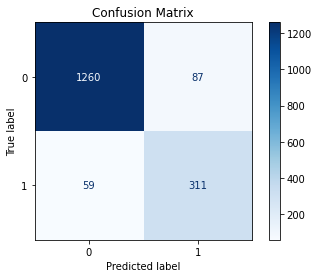

Text(0.5, 1.0, 'ROC CURVE')

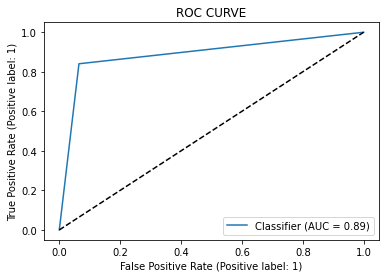

In [244]:

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#printing ROC curve
RocCurveDisplay.from_predictions(
    y_test,
    y_pred
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("ROC CURVE")


In [245]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1347
         1.0       0.78      0.84      0.81       370

    accuracy                           0.91      1717
   macro avg       0.87      0.89      0.88      1717
weighted avg       0.92      0.91      0.92      1717



- SUMMARY Results were't better even after under sampling & oversampling there was slight decrease in performace. So no under sampling was employed nor upsampling

## LSTM Modeling